# DataStorm 2.0

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTENC
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

## Import Data

In [2]:
train_data = pd.read_csv('../Data/Hotel-A-train.csv')

validation_data = pd.read_csv('../Data/Hotel-A-validation.csv')

test_data = pd.read_csv('../Data/Hotel-A-test.csv')

train_data

,Reservation-id,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,Booking_date,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate
0,39428300,F,40,Latino,Grad,<25K,North,City Hotel,7/1/2015,7/2/2015,5/21/2015,2,2,0,BB,No,No,No Deposit,Online,Yes,Check-In,Yes,10,218
1,77491756,F,49,Latino,Mid-School,50K -- 100K,East,City Hotel,7/1/2015,7/2/2015,5/26/2015,3,3,0,BB,No,No,Refundable,Online,Yes,Check-In,No,0,185
2,73747291,F,42,caucasian,Grad,<25K,East,City Hotel,7/2/2015,7/6/2015,6/29/2015,3,3,0,BB,No,No,No Deposit,Online,Yes,Check-In,No,0,119
3,67301739,M,25,African American,College,>100K,South,Airport Hotels,7/2/2015,7/3/2015,6/20/2015,4,3,0,BB,No,No,Refundable,Agent,Yes,Check-In,Yes,5,144
4,77222321,F,62,Latino,High-School,25K --50K,East,Resort,7/3/2015,7/4/2015,6/20/2015,1,1,0,BB,No,No,No Deposit,Direct,No,Check-In,Yes,10,242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27494,15645505,F,49,African American,Mid-School,<25K,West,City Hotel,8/31/2016,9/1/2016,7/25/2016,1,2,1,HB,Yes,Yes,No Deposit,Online,Yes,Check-In,Yes,10,100
27495,56414525,F,49,Asian American,College,25K --50K,South,Airport Hotels,8/31/2016,9/1/2016,4/26/2016,2,1,0,BB,No,No,Refundable,Agent,Yes,No-Show,Yes,40,194
27496,52023375,F,49,Latino,High-School,50K -- 100K,South,Airport Hotels,9/1/2016,9/2/2016,8/23/2016,2,1,1,HB,No,No,No Deposit,Direct,Yes,Check-In,Yes,5,202
27497,98041387,M,65,African American,College,25K --50K,South,Airport Hotels,8/31/2016,9/1/2016,5/25/2016,3,2,0,FB,No,No,No Deposit,Online,No,Canceled,Yes,20,157


## Import Data Sets

In [3]:
train_headers = train_data.columns
print(len(train_headers))
train_headers

24


Index(['Reservation-id', 'Gender', 'Age', 'Ethnicity', 'Educational_Level',
       'Income', 'Country_region', 'Hotel_Type', 'Expected_checkin',
       'Expected_checkout', 'Booking_date', 'Adults', 'Children', 'Babies',
       'Meal_Type', 'Visted_Previously', 'Previous_Cancellations',
       'Deposit_type', 'Booking_channel', 'Required_Car_Parking',
       'Reservation_Status', 'Use_Promotion', 'Discount_Rate', 'Room_Rate'],
      dtype='object')

## Data Formatting

In [4]:
def conv_date(data_set):
    booking_date = pd.to_datetime(data_set['Booking_date'])
    expected_checkin = pd.to_datetime(data_set['Expected_checkin'])
    expected_checkout = pd.to_datetime(data_set['Expected_checkout'])

    booking_delta = pd.DataFrame((expected_checkin - booking_date).dt.days, columns=['booking_delta'])
    stay_delta =  pd.DataFrame((expected_checkout - expected_checkin).dt.days, columns=['stay_delta'])
    return pd.concat([data_set, booking_delta, stay_delta], axis=1)


train_data = conv_date(train_data)
validation_data = conv_date(validation_data)
test_data = conv_date(test_data)

In [5]:
# columns
cat_data = ['Gender','Ethnicity','Educational_Level','Income','Country_region','Hotel_Type','Meal_Type','Visted_Previously','Previous_Cancellations','Deposit_type','Booking_channel','Required_Car_Parking','Use_Promotion']
num_data = ['Age', 'Adults', 'Children', 'Babies', 'Discount_Rate', 'Room_Rate']

drop_data = ['Reservation-id','Expected_checkin', 'Expected_checkout', 'Booking_date']

for element in drop_data:
    if element in cat_data:
        cat_data.remove(element)
    if element in num_data:
        num_data.remove(element)

print("Total Fields =", len(cat_data + drop_data + num_data))


def format_data(data_set, is_test=False):
    f_data_set = pd.get_dummies(data_set, prefix=cat_data, columns=cat_data)
    f_data_set = f_data_set.drop(drop_data, axis = 1)
    if(is_test):
        x = f_data_set
        global columns
        columns = x.columns
        return np.array(x)
    else:
        x = f_data_set.drop('Reservation_Status', axis = 1)
        y = f_data_set['Reservation_Status']
        return np.array(x), np.array(y)

x_train, y_train = format_data(train_data)
x_val, y_val = format_data(validation_data)
x_test = format_data(test_data, is_test=True)

print(len(x_train), len(x_val), len(x_test))
pd.DataFrame(y_val).head(10)

Total Fields = 23
27499 2749 4318


,0
0,No-Show
1,Canceled
2,Canceled
3,Check-In
4,Check-In
5,Canceled
6,No-Show
7,Canceled
8,Check-In
9,Check-In


## Normalize Data

In [6]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

pd.DataFrame(x_train, columns=columns).head(10)

,Age,Adults,Children,Babies,Discount_Rate,Room_Rate,booking_delta,stay_delta,Gender_F,Gender_M,Ethnicity_African American,Ethnicity_Asian American,Ethnicity_Latino,Ethnicity_caucasian,Educational_Level_College,Educational_Level_Grad,Educational_Level_High-School,Educational_Level_Mid-School,Income_25K --50K,Income_50K -- 100K,Income_<25K,Income_>100K,Country_region_East,Country_region_North,Country_region_South,Country_region_West,Hotel_Type_Airport Hotels,Hotel_Type_City Hotel,Hotel_Type_Resort,Meal_Type_BB,Meal_Type_FB,Meal_Type_HB,Visted_Previously_No,Visted_Previously_Yes,Previous_Cancellations_No,Previous_Cancellations_Yes,Deposit_type_No Deposit,Deposit_type_Non-Refundable,Deposit_type_Refundable,Booking_channel_Agent,Booking_channel_Direct,Booking_channel_Online,Required_Car_Parking_No,Required_Car_Parking_Yes,Use_Promotion_No,Use_Promotion_Yes
0,0.423077,0.25,0.5,0.0,0.250,0.786667,0.063202,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.596154,0.50,1.0,0.0,0.000,0.566667,0.056180,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.461538,0.50,1.0,0.0,0.000,0.126667,0.009831,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.134615,0.75,1.0,0.0,0.125,0.293333,0.022472,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.846154,0.00,0.0,0.0,0.250,0.946667,0.023876,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5,0.307692,1.00,0.5,0.5,0.250,0.286667,0.023876,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
6,0.673077,0.25,0.0,0.0,0.625,0.746667,0.004213,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
7,0.423077,0.25,0.0,0.0,0.000,0.466667,0.016854,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
8,0.788462,0.50,0.5,0.0,0.250,0.966667,0.123596,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
9,0.057692,0.25,1.0,0.0,0.500,0.746667,0.106742,0.666667,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


## Correlation Matrix

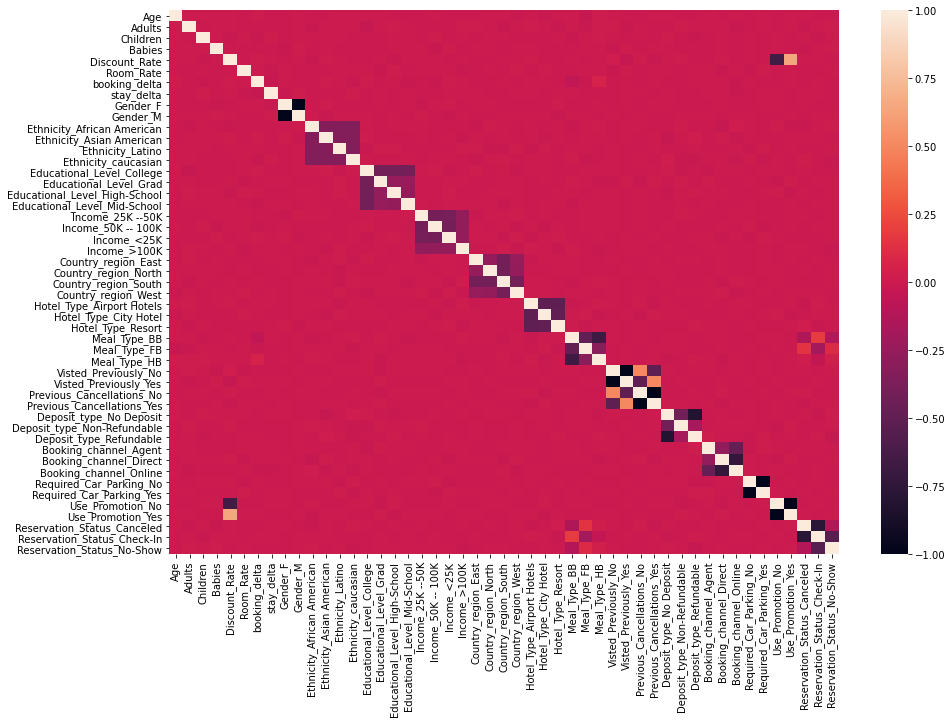

In [7]:
x_data_set = pd.DataFrame(x_train, columns=columns)
y_data_set = pd.get_dummies(pd.DataFrame(y_train), prefix=['Reservation_Status'])

corr = x_data_set.join(y_data_set).corr()

fig, ax = plt.subplots(figsize=(15, 10))
sb.heatmap(corr)
plt.show()

## UpSampling

In [8]:
cat_indx =range(8, len(columns))
sm = SMOTENC(categorical_features=cat_indx, random_state=0, k_neighbors=4)

x_train_res, y_train_res = sm.fit_resample(np.array(x_train), np.array(y_train))


## Model Training

In [9]:
# Random Forrest Classifier

classifier = RandomForestClassifier(bootstrap=True, class_weight= None, max_depth= 8, 
                                    max_leaf_nodes= None, min_samples_leaf= 1, min_samples_split= 2, 
                                    min_weight_fraction_leaf= 0.0, n_estimators= 200, n_jobs= 1, 
                                    oob_score= False, random_state= 85, verbose= 0, warm_start= False)
# XGBoost Classifier

classifier = XGBClassifier(silent=False, 
                           scale_pos_weight=1,
                           learning_rate=0.1,  
                           colsample_bytree = 0.4,
                           subsample = 0.8,
                           n_estimators=30, 
                           reg_alpha = 0.3,
                           max_depth=8,
                           gamma=10)

## Parameter Tuning

In [10]:
tuning_list = [5, 10, 15, 20, 25, 30]

# Divide validation set into two sets(validation and test)
x_val1, x_val2, y_val1, y_val2 = train_test_split(x_val, y_val, train_size=0.8, random_state=10)

for number in tuning_list:
    classifier = XGBClassifier(n_estimators=number, max_depth=5)
    classifier.fit(x_train_res, y_train_res)
    y_pred1 = classifier.predict(x_val1)
    print('Param_value :', number, '=>', 
          'F1_Score :', f1_score(y_val1, y_pred1, average='macro'), 
          'Accuracy :', classifier.score(x_val1, y_val1))

Param_value : 5 => F1_Score : 0.3134097100614916 Accuracy : 0.37835379718053663
Param_value : 10 => F1_Score : 0.32173875460130125 Accuracy : 0.394724874943156
Param_value : 15 => F1_Score : 0.3388980906680276 Accuracy : 0.42519326966803095
Param_value : 20 => F1_Score : 0.34484113654241894 Accuracy : 0.44793087767166895
Param_value : 25 => F1_Score : 0.335620121349778 Accuracy : 0.4620281946339245
Param_value : 30 => F1_Score : 0.33861331668311284 Accuracy : 0.4793087767166894


In [11]:
classifier = XGBClassifier(n_estimators=15, max_depth=5)

classifier.fit(x_train_res, y_train_res)

y_pred = classifier.predict(x_val)
y_pred2 = classifier.predict(x_val2)

print('Accuracy =', classifier.score(x_val, y_val))
print('F1 Score =', f1_score(y_val, y_pred, average='macro'))

print('Accuracy =', classifier.score(x_val2, y_val2))
print('F1 Score =', f1_score(y_val2, y_pred2, average='macro'))

Accuracy = 0.42088032011640597
F1 Score = 0.33567843900292904
Accuracy = 0.4036363636363636
F1 Score = 0.32201542976854225


## Inference

In [12]:
y_test = classifier.predict(np.array(x_test))

y_test

array(['No-Show', 'No-Show', 'Check-In', ..., 'Canceled', 'Check-In',
       'Check-In'], dtype=object)

In [13]:
y_test_mapped = pd.Series(y_test).map({'Check-In':1,'Canceled':2,'No-Show':3})
y_test_mapped.index = test_data['Reservation-id']
y_test_mapped.to_csv('results/Submission.csv', header=['Reservation_status'])

y_test_mapped.head(20)


Reservation-id
62931593    3
70586099    3
4230648     1
25192322    2
80931528    1
64700386    1
16938050    1
90487908    3
5595445     1
17502557    1
92229895    1
27386334    3
76765181    1
40697301    3
63963888    2
27282946    3
8696141     1
52621292    1
21821230    1
12316731    3
dtype: int64